In [1]:
# ! pip install -e ../../savo

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
# import concurrent
from copy import deepcopy as copy
# def sleep():
#     time.sleep(0.2)
# def clear_output(wait=True):
#     return display.clear_output(wait=wait)

In [3]:
import objFuncs
from objFuncs import VM
from objFuncs.util import plot_obj_history
from savo import savo

objFuncs version: 1.1.0. updated on 2023-12-04


flame_utils is not importable. ignoreing this feature...


In [4]:
ndim = 200
latent_ndim = 2
budget = 300
ninit = 64  # number of initial ES steps to collect data for surrogate model training
noise = 0.0

In [5]:
decision_CSETs=['X'+str(i) for i in range(ndim)]
decision_min = -1
decision_max =  1
x_bounds = np.array([(decision_min,decision_max)]*ndim)
max_dx = np.ones(ndim)*0.01  # maximum step size each iter
lr = 0.05

In [6]:
objective_RDs    = ['obj']
objective_goal   = {'obj': {'more than': 1.0}}
objective_norm   = {'obj': 1.0}
objective_weight = {'obj': 1.0}

# obj_func

: rastirigin over 2D latent space of random NN for both high-dim and visualization

In [7]:
import torch
layers = [
    torch.nn.Linear(ndim, 256),torch.nn.ELU(),
    torch.nn.Linear( 256, 256),torch.nn.ELU(),
    torch.nn.Linear( 256,   2)
    ]
_compressor_torch = torch.nn.Sequential(*layers)

def compressor(x,ndim=ndim):
    x = torch.tensor(x.reshape(-1,ndim)).to(torch.float32)
    z = _compressor_torch(x)
    return 7*z.detach().numpy()  # factor 7 for output var about 1


x = np.random.randn(1024*64,ndim);
y = compressor(x);
y.mean(), y.std()

(-0.25778642, 1.0238727)

In [8]:
def rastrigin(x,noise=noise):
    if x.ndim == 1:
        return np.sum(x**2 - np.cos(2*np.pi*x))/len(x)+1
    else:
        b,d = x.shape
        y = np.sum(x**2 - np.cos(2*np.pi*x),axis=1)/d +1
        if d==1:
            return float(y) + np.random.randn()*noise
        else:
            return y + np.random.randn(b)*noise

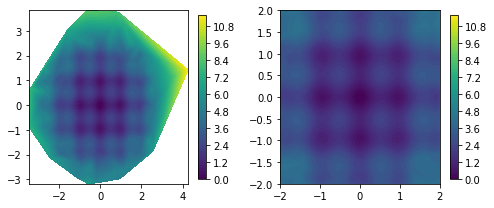

In [9]:
x = np.random.randn(2048,2)
y = rastrigin(x)

fig, ax = plt.subplots(1,2,figsize=(7,3))
cs = ax[0].tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax[0],shrink=0.95)
cs = ax[1].tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax[1],shrink=0.95)
ax[1].set_xlim(-2,2);
ax[1].set_ylim(-2,2);
fig.tight_layout()

In [10]:
# inverse rastirigin for maximization problem.  
def obj_function_raw(x):
    return 1-rastrigin(compressor(x))  #global optimum value is 1.

# objective function in Virtual EPICS machine using obj_function_raw

In [11]:
vm = VM(
        fun = obj_function_raw,
        decision_CSETs = decision_CSETs,
        objective_RDs  = objective_RDs,
        x0 = np.zeros(ndim)
        );

In [12]:
objFuncs._global_machineIO.ensure_set = vm.ensure_set
objFuncs._global_machineIO.fetch_data = vm.fetch_data
objFuncs._global_machineIO._test = True

In [13]:
obj0 = objFuncs.objFuncGoals(
    decision_CSETs= decision_CSETs,
    decision_min  = decision_min,
    decision_max  = decision_max,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
    apply_bilog = False,
    init_verbose = False,
    );

# random initial decision point away from optimum 

In [14]:
obj = copy(obj0)
y0 = 1
while(y0 > -1):
    x0 = np.random.rand(1,ndim)*(decision_max-decision_min)+decision_min
    y0 = np.mean(obj(x0))
y0

-1.1455336809158312

# Pure ES

In [15]:
obj = copy(obj0)
plot_RDs = plot_obj_history( obj.history['objective_RDs'] )
callbacks = [plot_RDs]
def obj_callbacks(x):
    return obj(x,callbacks=callbacks)

sv = savo(obj_func= obj_callbacks,
          x0 = x0,
          max_dx = max_dx,
          x_bounds = x_bounds,
          )

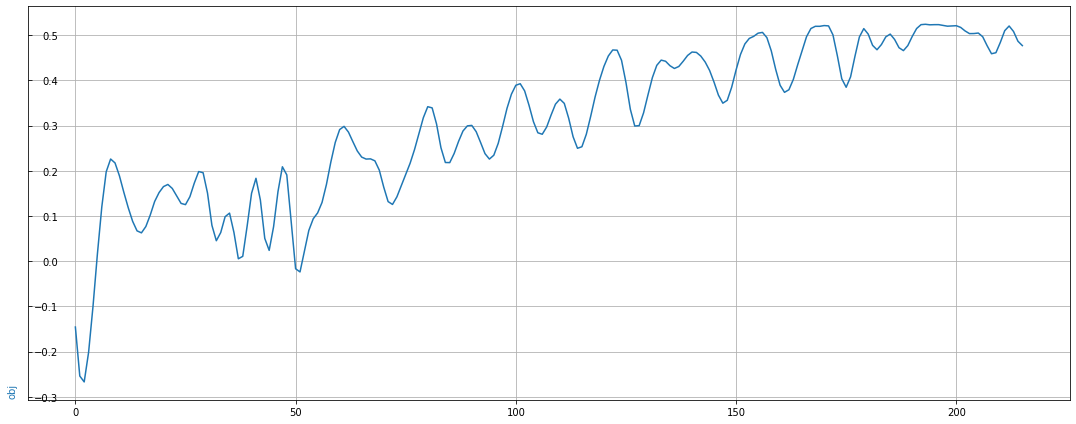

In [ ]:
sv.runES(budget)
plot_RDs.close()

In [ ]:
fig, ax = plt.subplots(figsize=(3.5,3))
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95)
z = compressor(np.array(obj.history['decision_CSETs']['values']))
ax.plot(z[:,0],z[:,1],color='r')
ax.scatter(z[0,0],z[0,1],marker='x',color='r',s=1)
ax.set_xlim(-2,2);
ax.set_ylim(-2,2);
fig.tight_layout()

# SAVO with ES

In [ ]:
obj = copy(obj0)
plot_RDs = plot_obj_history( obj.history['objective_RDs'] )
callbacks = [plot_RDs]
def obj_callbacks(x):
    return obj(x,callbacks=callbacks)

sv = savo(obj_func= obj_callbacks,
            x0 = x0,
            max_dx = max_dx,
            x_bounds = x_bounds,
            )

In [ ]:
sv.runES(ninit)
sv.run_savo(budget-ninit,lambdaES=1,lr=lr)
plot_RDs.close()

In [ ]:
fig, ax = plt.subplots(figsize=(3.5,3))
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95)
z = compressor(np.array(obj.history['decision_CSETs']['values']))
ax.plot(z[:,0],z[:,1],color='r')
ax.scatter(z[0,0],z[0,1],marker='x',color='r',s=1)
ax.set_xlim(-2,2);
ax.set_ylim(-2,2);
fig.tight_layout()

# SAVO without ES

In [ ]:
obj = copy(obj0)
plot_RDs = plot_obj_history( obj.history['objective_RDs'] )
callbacks = [plot_RDs]
def obj_callbacks(x):
    return obj(x,callbacks=callbacks)

sv = savo(obj_func= obj_callbacks,
            x0 = x0,
            max_dx = max_dx,
            x_bounds = x_bounds,
            )

In [ ]:
sv.runES(ninit)
sv.run_savo(budget-ninit,lambdaES=0,lr=lr)
plot_RDs.close()

In [ ]:
fig, ax = plt.subplots(figsize=(3.5,3))
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95)
z = compressor(np.array(obj.history['decision_CSETs']['values']))
ax.plot(z[:,0],z[:,1],color='r')
ax.scatter(z[0,0],z[0,1],marker='x',color='r',s=1)
ax.set_xlim(-2,2);
ax.set_ylim(-2,2);
fig.tight_layout()